# cflowpy

A python package to solve the incompressible Navier-Stokes Equation with Chorins projection method.

- Author: Jan Habscheid
- E-mail: Jan.Habscheid@rwth-aachen.de

# Purpose of this package

The purpose of this package is to **predict the flow of an incompressible fluid** on a computational domain.\
It aims to predict the *velocity* and the *pressure field* over the domain.\
The goal is to make this *easy accessable* to everyone.\
The reproducibility of fluid simulations *without in-depth knowledge* in computational fluid simulations should be possible.\
It further enables the user to *define* their *own pyhsical problem* with different boundary conditions and initial conditions and to run simulations for this physical problem.

# The Equation

The incompressible Navier-Stokes equation in the differential form of the momentum equation states:

\begin{align*}
\frac{\partial \pmb{u}}{\partial t} + (\pmb{u} \cdot \nabla)\pmb{u} = -\frac{1}{\rho} \nabla p + \nu \nabla^2\pmb{u} + g
\end{align*}

with the additional constraint: $\nabla \cdot u = 0$ for incompressibility

The variables are:
- $\pmb{u}$: flow velocity $\frac{mm}{s}$
    - vector field for velocity in x and in y-direction
- $t$: time $s$
- $\rho$: density $\frac{kg}{mm^3}$
- $p$: pressure $\frac{N}{m^2}=\frac{kg}{mm \cdot s^2}$
- $\nu$: kinematic viscosity cSt
    - note: 1cSt(centiStoke) = $1\frac{mm^2}{s}=10^{-6}\frac{m^2}{s}$
- $g$: body accelerations $\frac{mm}{s^2}$
    - In this implementation the body accelerations are set to zero and not implemented

## The Discretization

### Spatial discretization

**Finite Differences** are used to discretize the physical domain.\
For now let's consider $u$ as the velocity in x-direction and  $v$ as the velocity in y-direction.
Discretizing the incompressible Navier-Stokes equation from above we get **two equations**, one for the x-direction and one for the y-direction, that are **coupled to each other**.
\begin{align*}
\frac{\partial u}{\partial t} &+ u \cdot \frac{\partial u}{\partial x} + v \cdot \frac{\partial u}{\partial y} = -\frac{1}{\rho} \frac{\partial p}{\partial x} + \nu (\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2})\\
\frac{\partial v}{\partial t} &+ u \cdot \frac{\partial v}{\partial x} + v \cdot \frac{\partial v}{\partial y} = -\frac{1}{\rho} \frac{\partial p}{\partial y} + \nu (\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2})
\end{align*}
Central finite differences are used to compute the derivates.\
For the purpose of this package the boundary of the domain is described with **Dirichlet or Neumann boundary conditions** and therefore the implemented functions to compute the derivates set the boundary of each derivative to zero.\
 The boundaries of the domain are updates according to the boundary conditions.
\begin{align*}
\frac{\partial u}{\partial x}(x,y) &= \frac{u(x+dx,y) - u(x-dx,y)}{2 \cdot dx}\\
\frac{\partial u}{\partial y}(x,y) &= \frac{u(x,y+dy) - u(x,y-dy)}{2 \cdot dy}\\
\frac{\partial^2 u}{\partial x^2}(x,y) &= \frac{u(x+dx,y) - 2\cdot u(x,y) +  u(x-dx,y)}{(dx)^2}\\
\frac{\partial^2 u}{\partial y^2}(x,y) &= \frac{u(x,y+dy) - 2\cdot u(x,y) +  u(x,y-dy)}{(dy)^2}
\end{align*}
The Laplace operator is derived by:
\begin{align*}
\Delta u(x,y) &= \frac{\partial^2 u}{\partial x^2}(x,y) + \frac{\partial^2 u}{\partial y^2}(x,y) \\
&= \frac{u(x+dx,y) - 2\cdot u(x,y) +  u(x-dx,y)}{(dx)^2} + \frac{u(x,y+dy) - 2\cdot u(x,y) +  u(x,y-dy)}{(dy)^2}
\end{align*}

### Time discretization

For **time integration** ($\frac{\partial u}{\partial t} = f(t,u(t))$)there are implemented two different numeric schemes.
- The *explicit Euler*
\begin{align*}
u^{(n+1)} = u^{(n)} + \Delta t f(t,u(t))
\end{align*}
- A *fourth order Runge-Kutta method*
which leads us to:
\begin{align*}
\frac{\partial u}{\partial t} &= f(t,u(t))\\
\Leftrightarrow u^{(n+1)} &= u^{(n)} + \frac{\Delta t}{6} (k1 + 2k2 + 2k3 + k4)
\end{align*}
with 
\begin{align*}
k1 &= f(t_i, u_i)\\
k2 &= f(t_i + \frac{\Delta t}{2}, u_i + \frac{\Delta t}{2}k_1)\\
k3 &= f(t_i + \frac{\Delta t}{2}, u_i + \frac{\Delta t}{2}k_2)\\
k4 &= f(t_i + \Delta t, u_i + \Delta t k_3)\\
\end{align*}

## The Model

The purpose of this python package is the **prediction of the flow of an incompressible fluid**.
Therefore, the incompressible Navier-Stokes Equation in the momentum equation are solved with **Chorin's projection** method.\
Chorin's projection method is a *splitted Algorithm*.\
First, only the viscous forces are taken into account and an intermediate velocity is caluclated.\
Second, the pressure forces are taken into account. Therefore a Poisson equation has to be solved and then the velocity is updated in time.\
Let's reconsider the incompressible Navier-Stokes equation in the differential form of the momentum equation.
\begin{align*}
\frac{\partial \pmb{u}}{\partial t} + (\pmb{u} \cdot \nabla)\pmb{u} = -\frac{1}{\rho} \nabla p + \nu \nabla^2\pmb{u} + g
\end{align*}

1. Step: 
    Compute an intermediate velocity $\pmb{u}^*$ by only taking the viscous forces into account.
    
    \begin{align*}
    \frac{\pmb{u}^* - \pmb{u}^n}{\Delta t} = -(\pmb{u}^n \cdot \nabla) \pmb{u}^n + \nu \nabla^2 \pmb{u}^n
    \end{align*}

2. Step:
    Computing the velocity of the time step $\pmb{u}^(n+1)$ with the projection step where the intermediate velocity is corrected
    
    \begin{align*}
    \pmb{u}^{n+1} = \pmb{u}^* - \frac{\Delta t}{\rho}\nabla p^{n+1}
    \end{align*}

    To get $\nabla p^{n+1}$ we first need to solve a Poisson equation
    
    \begin{align*}
    \Delta p^{n+1} = \frac{\rho}{\Delta t} \nabla \cdot \pmb{u}^*
    \end{align*}

### Solving the Poisson equation

In this package the **Jacobi method** is used to solve the poisson equation.\
The Jacobi method is an interative method that uses the following discretization
\begin{align*}
\frac{p_{i+1,j} - 2\cdot p_{i,j} + p_{i-1,j}}{(\Delta x)^2} + \frac{p_{i,j+1} - 2\cdot p_{i,j} + p_{i,j+1}}{(\Delta y)^2} = \frac{\rho}{\Delta t} \nabla \cdot \pmb{u}^*_{i,j}\\
\Leftrightarrow 
p_{i,j} = \frac{1}{\frac{1}{(\Delta x)^2} + \frac{1}{(\Delta y)^2}} \left( \frac{p_{i+1,j} + p_{i-1,j}}{(\Delta x)^2} + \frac{p_{i,j+1} + p_{i,j-1}}{(\Delta y)^2} \right)
\end{align*}
The way it is implemented the above step is applied 100 times, by default.\
However, it is possible to adapt this amount of iterations or to state a residual to stop the iterations if two consecutive time steps do not differ very much from each other.

## Installation

Run

```console
pip install git+https://git.rwth-aachen.de/Jan.Habscheid/cflowpy
```

Alternative:\
Clone [https://git.rwth-aachen.de/Jan.Habscheid/cflowpy] and install ``cflowpy`` from the dist folder, e.g. for version 0.1

```console
pip install cflowpy-0.1-py3-none-any.whl
```

Now that cflowpy is installed in our local python environment we would like to make use of it.

# A few example usecases

### Importing the package

First, we need to import the package so that we are able to use it.

In [1]:
import cflowpy as cf

## Lid Driven cavity flow

Our first usecase is the lid-driven cavity flow where the lid is moving with a **tangential velocity of 1 on top** of our computational domain.\
If you would like to familiarise with the situation, you can read the documentation for further details.

First of all, we **define our physical problem** in form of the lid-driven cavity flow with a velocity of 1 on the top side of the domain.\
To do so we use the implementation for the Cavity:


In [2]:
physical_problem_cavity = cf.Cavity_flow(1, "top")

Now, we would like to **set up our system to solve it**.\
therefore we descriibe the computational domain as well as some material properties.\
We would like to have a domain on $x \in [0,10], y \in (0,10)$ and 30 Cells in both directions.\
In this case we would like to simulate water with a kinematic viscosity of 1 cSt and a density of 1$\frac{kg}{L}$

In [3]:
system_cavity = cf.System(0, 2, 30, 
                          0, 2, 30, 
                          0.1, 1, 
                          physical_problem_cavity)

Now we want to compute the velocities and the pressure after 1 second with a time step size of 0.01 seconds.

In [4]:
u_cavity, v_cavity, p_cavity = system_cavity.solve(0.01, 5, adapt_dt=0.5)

In [8]:
p_cavity[-1,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

The results are:
- u: the velocity in x-direction after 1 second
- v: the velocity in y-direction after 1 second
- p: the pressure field after one second

We can now visualize the results by using the implemented ```contourfigure``` visualization method.

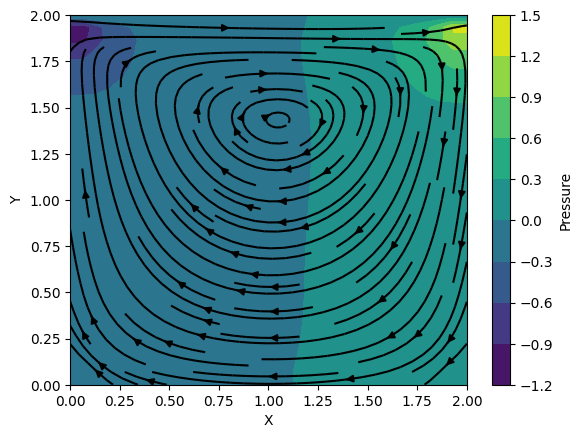

In [10]:
fig = system_cavity.contourfigure(u_cavity, v_cavity, p_cavity, velocity="streamline", )

We now would like to use the ```coolwarm``` colormap from ```matplotlib.pyplot``` and use a title.

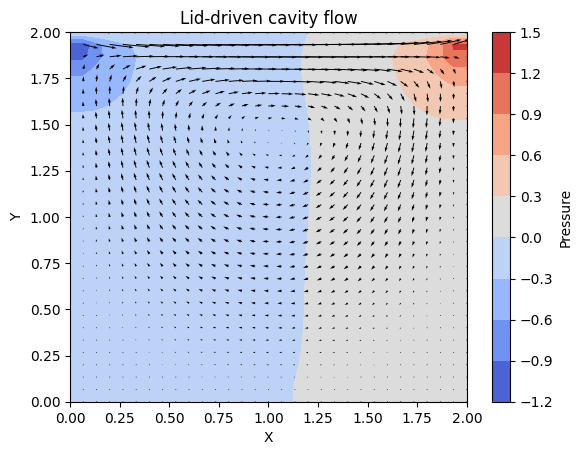

In [21]:
fig = system_cavity.contourfigure(u_cavity, v_cavity, p_cavity, 
                                  cmap="coolwarm", 
                                  title="Lid-driven cavity flow")

Now we would like to visualize the streamlines, this we can do with setting the optional argument ```velocity``` to "streamline"

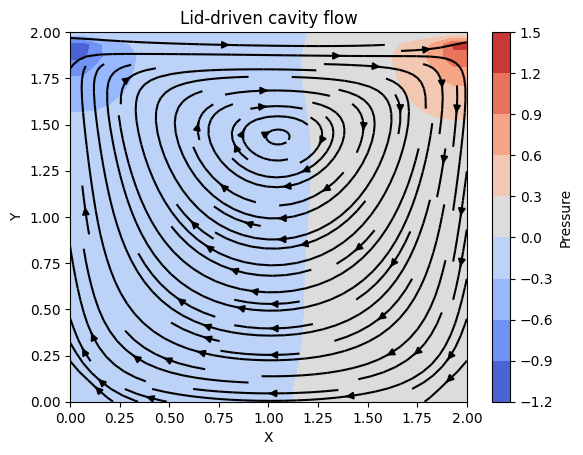

In [22]:
fig = system_cavity.contourfigure(u_cavity, v_cavity, p_cavity, 
                                  velocity="streamline", 
                                  cmap="coolwarm", 
                                  title="Lid-driven cavity flow")

If you would like to save the figure you can do this by using the optinal argument ```savefig``` where you define the desired place to save the figure.

### Saving the results

Let's now save the results of our simulation in an extern file.\
Therefore, we can use the ```save_data``` function from ```System```.\
It is even easier to run the simulation with the ```save_data``` argument specified.

In [23]:
u_cavity, v_cavity, p_cavity = system_cavity.solve(0.01, 1, save_data="data")

Now we could possible load the data with numpys ```load``` function and access them in a dictionary-like way.

```python
import numpy as np
data = np.load("data.npz")
x_coordinates = data["x"]
viscosity = data["viscosity"]
u = data["velocity_x_direction"]
print("x_coordinates used: ", x_coordinates)
print("viscosity used: ", viscosity)
```

# Pipe

Next, we would like to simulate a **fluid flow through a pipe** with an inlet velocity of 5.\
In this simulation we aim to verify that the velocity profile in a pipe is the **Hagen-Poiseulee velocity profile**.
At the top and bottom edge the no-slip condition is fullfilled.

In [24]:
physical_problem_pipe = cf.Pipe_flow(5)

We solve the problem on a domain of $x \in [0,10], y \in [0,2]$ with 25 cells in x and 5 cells in y-direction.\
Finally, we are interested in the solution after 5 seconds with a step size of 0.001.\
The explicit Euler is the default time integration method. However, we would now like to a Runge Kutta method of order 4.\
This can be done by setting the argument ```time_update``` to ```Runge_Kutta_4```.

In [25]:
system_pipe = cf.System(0, 10, 40,
                        0, 2, 20, 
                        0.1, 1,
                        physical_problem_pipe)
u_pipe, v_pipe, p_pipe = system_pipe.solve(0.01, 5, time_update="Runge_Kutta_4", adapt_dt = 0.5)

We can **visualize only the velocity**, without the pressure by setting ```contour``` to False:

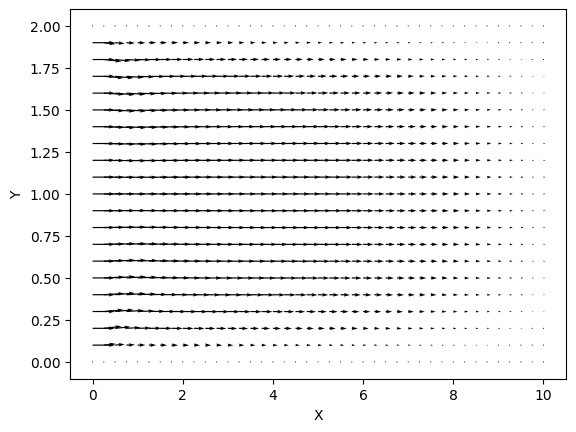

In [26]:
fig = system_pipe.contourfigure(u_pipe, v_pipe, p_pipe,
                                contour=False)

Additionally, we are interested in the velocity profile and if this a Hagen-Pouiseuille velocity profile.\
We can use the optional argument ```velocity_profile``` to visualize this. Therefore, a list has to be parsed to ```contourfigure``` with the indices of the discretization in x-direction, where the velocity profile should be displayed.

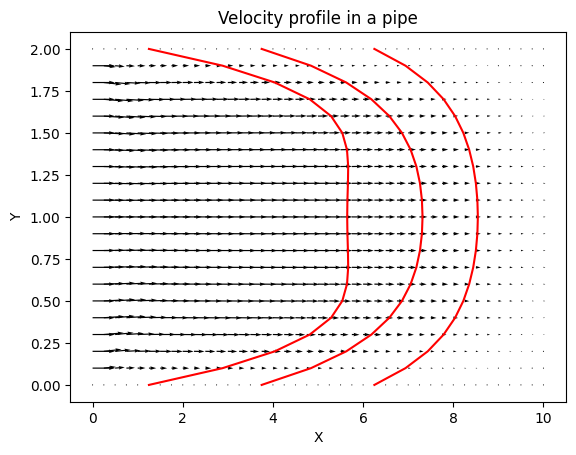

In [27]:
fig = system_pipe.contourfigure(u_pipe, v_pipe, p_pipe,
                                contour = False,
                                velocity_profile = [5, 15, 25],
                                title="Velocity profile in a pipe")

In this case, we can see that at the Hagen-Poiseuille profile build up over the length of the pipe.
However, by comparing this to the analytical solution, one can conclude that the magnitude is not correct.

## Pressure driven pipe flow

We try to fix the magnitude by prescribing the pressure and make use of ``Pipe_flow_pressure_driven``.\
For our purpose we use a viscosity of 0.1 cSt, a density of 1 $\frac{kg}{mm^3}$ and an inflow velocity of 5 $\frac{mm}{s}$.\
We prescribe the pressure with 10 $\frac{N}{mm^2}$ on the left side of the domain and 5 $\frac{N}{mm^2}$ on the right side of the domain.\
Since we are prescribing the pressure on the whole domain, we can set the number of iteration to solve the poisson equation to zero.

In [28]:
KINEMATIC_VISCOSITY = 0.1
DENSITY = 1
physical_problem_pipe_pressure_driven = cf.Pipe_flow_pressure_driven(0, 10, 0)
system_pipe_pressure = cf.System(0, 10, 25,
                        0, 2, 6, 
                        KINEMATIC_VISCOSITY, DENSITY,
                        physical_problem_pipe_pressure_driven)

u_pressure_pipe, v_pressure_pipe, p_pressure_pipe = system_pipe_pressure.solve(0.001, 10, 
                                                                                n_iteration_pressure_poisson = 0)

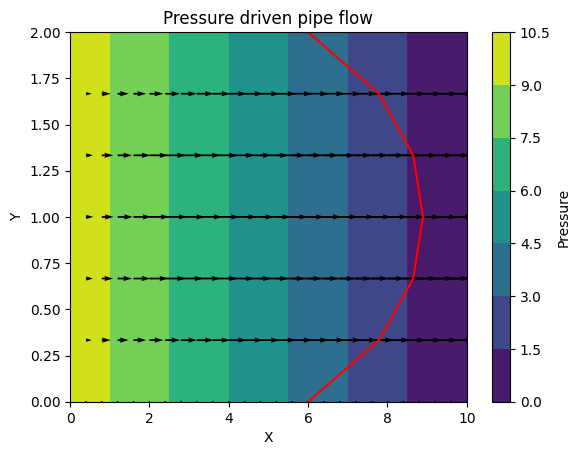

In [29]:
fig = system_pipe_pressure.contourfigure(u_pressure_pipe, v_pressure_pipe, p_pressure_pipe, 
                                         velocity_profile = [15],
                                         title="Pressure driven pipe flow")

Now we want to plot our velocity profile againt the analytical solution.

To do so, we need ``numpy`` and ``matplotlib``.\
``Hagen_Poiseuille`` calculates the analytical solution.\
The exact solution reads:

\begin{align*}
	u(x) = -\frac{R^2}{4\eta}\frac{dp}{dx} \cdot [1-(\frac{r}{R})^2]
\end{align*}

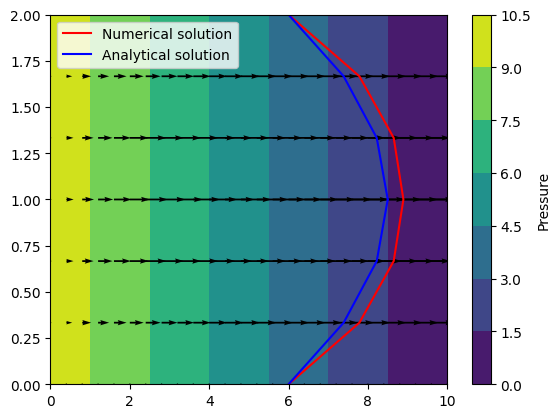

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def Hagen_Poiseuille(r:np.array,
                     R:float, 
                     dynamic_viscosity:float, 
                     p:np.ndarray, 
                     system:cf.System,
                     index:tuple):
    """
    Computes the Hagen-Poiseuille velocity profile

    Parameters
    ----------
    r : np.array
        Radius to compute the velocity profile on
    R : float
        Radius of the pipe
    viscosity : float
        viscosity of the fluid
    p : np.ndarray
        pressure
    system : cf.System
        system which has solved the numerical results
    index : tuple
        index where to calculate the velocity profile

    Returns
    -------
    np.ndarray
        Analytical solution
    """
    dpdx = system.grid.central_fd(p, 0, 1)
    v_max = -(R**2)/(4*dynamic_viscosity)*dpdx[index[0],index[1]]
    
    return v_max * (1-(r/R)**2)

# defining the dynamic viscosity
DYNAMIC_VISCOSITY = KINEMATIC_VISCOSITY * DENSITY

# visualize numerical results
fig, ax = plt.subplots()
contourf_ = ax.contourf(system_pipe_pressure.grid.get_x(), system_pipe_pressure.grid.get_y(), p_pressure_pipe)
plt.quiver(system_pipe_pressure.grid.get_x(), system_pipe_pressure.grid.get_y(), u_pressure_pipe, v_pressure_pipe)
plt.plot(15 * system_pipe_pressure.grid.get_dx() + u_pressure_pipe[:,15], system_pipe_pressure.grid.get_y()[:,15], color="red", label="Numerical solution")
fig.colorbar(contourf_, label="Pressure")

# visualize analytical solution
r_top = np.linspace(0, 1, 4)
r_bottom = np.linspace(1, 0, 4)
Hagen_bot = Hagen_Poiseuille(r_bottom, 1, DYNAMIC_VISCOSITY, p_pressure_pipe, system_pipe_pressure, (3,15))
Hagen_top = Hagen_Poiseuille(r_top, 1, DYNAMIC_VISCOSITY, p_pressure_pipe, system_pipe_pressure, (3,15))
plt.plot(15 * system_pipe_pressure.grid.get_dx() + Hagen_top, system_pipe_pressure.grid.get_y()[3:,15], color="blue", label="Analytical solution")
plt.plot(15 * system_pipe_pressure.grid.get_dx() + Hagen_bot, system_pipe_pressure.grid.get_y()[:4,15], color="blue")
plt.legend()

As we can see, the numerical solution is close to the analytical solution, but not complete right.\
However, for certain viscosities, inflow values and pressure differences, this can difference can get arbitrary large.\
Therefore, we can conclude that we get the Hagen-Poiseuille velocity profile, but with a wrong magnitude.

# Pipe with a backward facing step

Now we would like to simulate a **pipe with a backward facing step.**\
This one is similar to the "normal" pipe flow.\
However, as it says, on the left side of the domain there is a pipe with a backward facing step.\
**Inside the step** all velocities and the pressure are set to zero.\
So let's think about our expected results.\
We would expect to see three different things.\
First, we would expect a **Hagen-Poiseuilee velocity profile above the step**.\
Second, we would expect a **slightly shifted Hagen-Poiseulee** velocity profile far enough **behind the step.**\
Third, **vortexes** are expected to occur directly behind the step.

So let's get startet with this.

We would like to have an inflow velocity of 3.\
Furthermore, we need to specify the step.\
Therefore, it is **important** to keep one thing in mind.\
The values we give to describe the step are just the indices for the end of the step in the vector describing our physical domain, not the physical value itself.\
For now we would like to verify the end of the step in x-direction at the 70th index of our x vector and at the 40th index in our y-vector.

In [31]:
physical_problem_pipe_step = cf.Pipe_with_a_backward_facing_step(60, 20, 5)
system_pipe_step = cf.System(0, 15, 200,
                             0, 5, 100,
                             0.1, 1,
                             physical_problem_pipe_step)

```python
u, v, p = system.solve(0.001, 1)
```

If we would run our simulation with the setup from above it would stop very fast because the cfl-condition would not be fullfilled in each time step.\
However, we would like to fullfill the cfl-condition to ensure stability. So we can use the ```adapt_dt``` argument.\
If the cfl-condition is not fullfilled we would like to adapt the time step size so that the cfl-condition is set to a value of 0.5.\
This can cause much higher compute time since the time step could go very low. To speed up the compute time we set the number of Jacobi iterations to solve the Poisson equation to 50, instead of the default value of 100. This can lead to more inaccurate solutions for the pressure correction, but for our situation this is no problem.

In [32]:
u_pipe_step, v_pipe_step, p_pipe_step = system_pipe_step.solve(0.01, 1,
                                                               n_iteration_pressure_poisson = 50,
                                                               adapt_dt = 0.5)

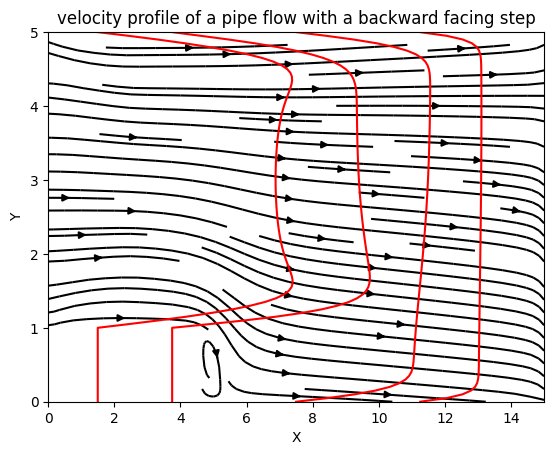

In [33]:
fig = system_pipe_step.contourfigure(u_pipe_step, v_pipe_step, p_pipe_step, 
                                     contour=False, velocity="streamline",
                                     velocity_profile = [20, 50, 100, 150],
                                     title="velocity profile of a pipe flow with a backward facing step")

One more time we try to verify our results.\
We can see the expected vortex behind the step.\
However, the Hagen-Poiseuille velocity profile does not occur.\
Bevor the step we can verify that we get closer to the Hagen-Poiseuille velocity profile as more we get into the pip and the same occurs after the step, but we do not reach this velocity profile.\
The reason for this migh be that the compuational domain is not large enough.

# Conclusion

To conclude, one can see that this package is capable to predict the velocity and pressure profile of many different physical situations, like a pipe, a pipe with a backward facing step or a cavity flow, with just slight adaptation.\
It is also possible to simulate even more physical situations. Therefore, everybody can implement it's own childclass from the parentclass ```PhysicalProblem```, with at least the two function ```apply_boundary_conditions_velocity``` and ```apply_boundary_conditions_pressure```.\
If a specific starting point is wished this can be specified in ```initialize_system``` from the ```PhysicalProblem``` class.

However, it is important to note that this computations aren't exact.\
For the pipe for example, the analytical solution might be far away from the numerical, for different boundary conditions.\
Therefore, it is important to take the correct boundary conditions ans to keep in mind that this is a rather simple Navier-Stokes solver that is not able to simulate every situation with every discretization.\
For very corse or very fine discretizations there might occur some errors or the numerical solutions will be not very good.\
Overall, this solver is capable to give us qualitative courses of different physical problems, but maybe the absolute values won't fit perfectly.